#Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields

This notebook is exploring the algorithm for human pose estimation OpenPose. The original repository is in https://github.com/CMU-Perceptual-Computing-Lab/openpose and the pytorch implementation used here comes from  https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation

## Introduction

The estimation of human posture is the process of modeling the human body as a set of some parts (e.g., arms, legs, torso, etc.) and finding their positions in an image. Several studies have been developed in order to generate these estimates in real time using various techniques of Deep Learning. In this Notebook we study the development done in [[1]](https://ieeexplore.ieee.org/document/8099626), which makes use of Part Affinity Fields for this purpose.

Inferring the pose of multiple people in images, especially socially engaged individuals, presents a unique set of challenges. First, each image may contain an unknown number of people that can occur at any position or scale. Second, interactions between people induce complex spatial interference, due to contact, occlusion, and limb articulations, making association of parts difficult. Third, runtime complexity tends to grow with the number of people in the image, making realtime performance a challenge. The Caffe implementation (C++ with a python interface) is in https://github.com/CMU-Perceptual-Computing-Lab/openpose 

In [[1]](https://ieeexplore.ieee.org/document/8099626), a method for estimating the posture of various persons at multiple public reference points is presented. It uses the ascending representation of association scores through the part affinity fields (PAF), a set of 2D vector fields that encode the location and orientation of the limbs over the image domain. These bottom-up representations of detection and association are simultaneously inferred and encode the global context of the scene.

We will exploit a PyTorch implementation. If you wish a quick tutorial to PyTorch, you can look at https://pytorch.org/tutorials/beginner/nn_tutorial.html.

In [12]:
# Libraries
# Colab libraries
from google.colab import drive
from google.colab import output
drive.mount('/content/gdrive')
colab_path = "/content/gdrive/My Drive/Colab Notebooks/"

# Basis libraries
import os, re, sys, math, time, scipy, argparse
import cv2, matplotlib
import matplotlib.gridspec as gridspec
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.morphology import generate_binary_structure
from scipy.ndimage.filters import gaussian_filter, maximum_filter

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Settings

First, we install the necessary packages

In [13]:
# Independence install
!sudo apt-get install swig


# Repository compile
%cd "RT-multiperson-pose-pytorch"
%cd lib/pafprocess 
!sh make.sh

# Libraries install
%cd $colab_path"RT-multiperson-pose-pytorch"
!python -m pip install -r ./requirements.txt
!pip3 install numpngw

print("[INFO]: Project requirements installed successfully")

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
[Errno 2] No such file or directory: 'RT-multiperson-pose-pytorch'
/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch/lib/pafprocess
running build_ext
/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
[INFO]: Project requirements installed successfully


Now, we can import others libraries use in the project, contained in the repository.

In [14]:
# Framework libraries
%cd $colab_path"RT-multiperson-pose-pytorch"
sys.path.append('.'); sys.argv=['']
from lib.network.rtpose_vgg import get_model 
from lib.network import im_transform
from evaluate.coco_eval import get_outputs, handle_paf_and_heat
from lib.utils.common import Human, BodyPart, CocoPart, CocoColors, CocoPairsRender, draw_humans
from lib.utils.paf_to_pose import paf_to_pose_cpp
from lib.config import cfg, update_config
from torchsummary import summary
from evaluate.coco_eval import get_outputs, handle_paf_and_heat, run_eval

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch


And update the variables space.

In [15]:
###########NETWORK CONFIG ############
class Namespace:
  def __init__(self, **kwargs):
    self.__dict__.update(kwargs)

# update config file
args = Namespace(cfg = './experiments/vgg19_368x368_sgd.yaml', weight = 'pose_model.pth', opts = [])
update_config(cfg, args)

## **Network understanding**

In general terms, the method developed for the Multi-Person 2D Pose Estimation is divided into several stages. In the figure, the general architecture of the system is shown. 

First, the system takes, as input, a $wxh$ size colour image,  the image is  analyzed by a convolutional network (initialized by the first 10 layers of VGG-19  and finetuned), generating a set of feature maps that is input to the first stage of 2 branchs. The two brach correspond to the parts of a feedforward network that simultaneously predicts, first a 2D confidence set $S = (S_{1},S_{2},...,S_{J})$ maps of the locations of the body parts $J$ one per location  (RKnee,Shoulder,Hip, etc) where 
$S_{j}\in \mathbb{R}^{wxh}, j \in {1,...,J}$; 
and a set of 2D vector fields of the affinities of the parts 
$L = (L_{1},L_{2},...,L_{C})$ , which encode the degree of association between the parts ,it has $C$ vector fields, one per limb( pairs of body parts ), where
 $L_{c}\in \mathbb{R}^{wxhx2},c \in {1,...,C}$


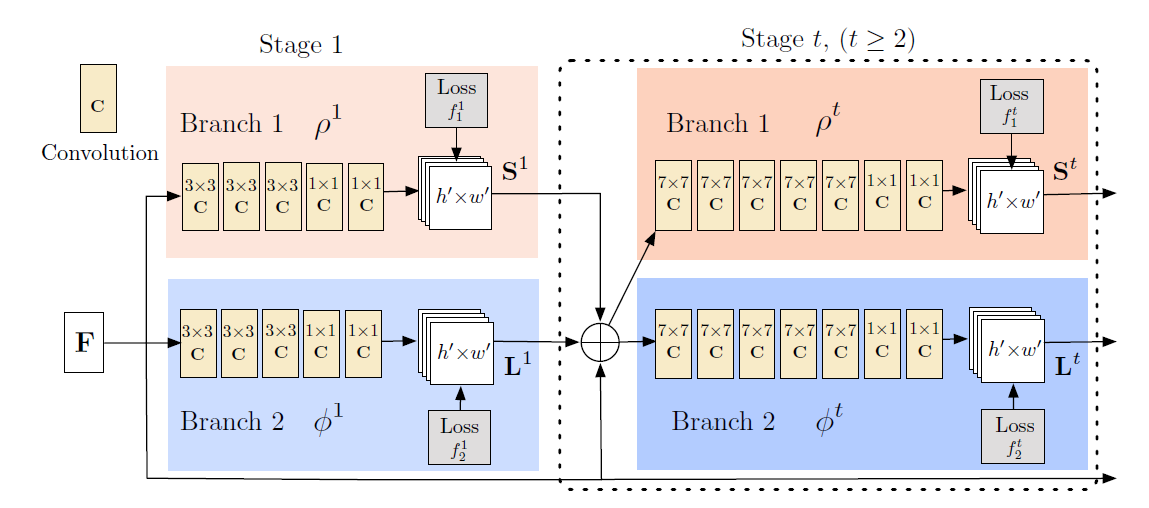

Next we will use the code picture_demo.py in order to explain the composition of the network, and the processes that are made in order to obtain the estimation of poses, considering that it is already trained

### ***Model extraction***

Initially, the input dimension image () is introduced into the first 10 layers of the CNN VGG-19 model, which is normally used for image classification, and produces a set of feature maps F that is input to the first stage of each branch.

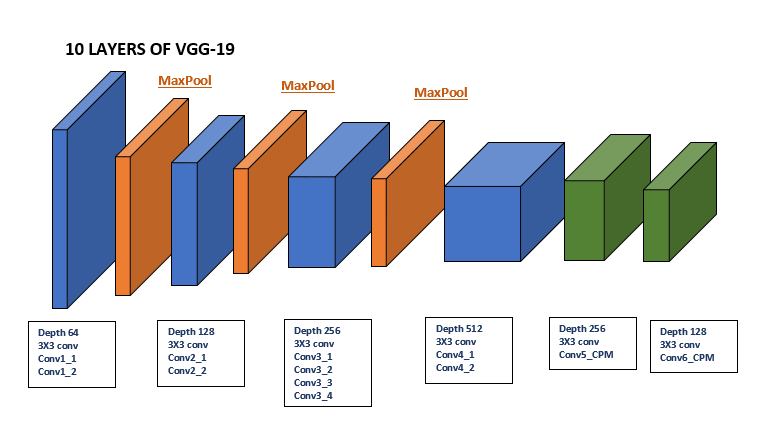

In order to make the prediction of the confidence maps (**S**) and the vector fields of the affinity of the parts PAFs (**L**) two brachs were designed, which are composed of 6 stages, however the process of optimization and execution is done in parallel. 

At the first stage, the network produces a set of detection confidence maps $S_{1} = \rho^{1} (F)$ and a set of part affinity fields $L_{1} = \phi^{1}(F)$, where $\rho^{1}$ and $\phi^{1}$ are the CNNs for inference at Stage 1. In each subsequent stage, the predictions from both branches in the previous stage,along with the original image features $F$, are concatenated and used to produce refined predictions, in other words a recurrent neuronal network (RNN).

$$S^{t} = \rho ^{t}(F,S^{t-1},L^{t-1}),\forall t \geq 2 $$

$$L^{t} = \phi ^{t}(F,S^{t-1},L^{t-1}),\forall t \geq 2 $$


The following figures present in more detail each subnetwork

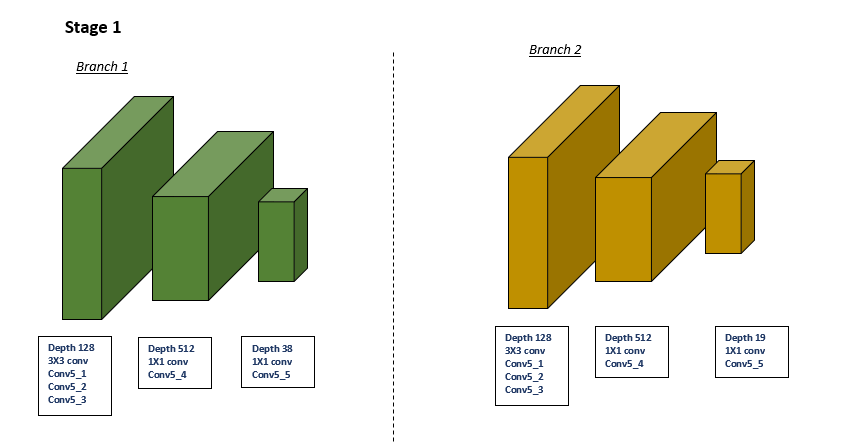

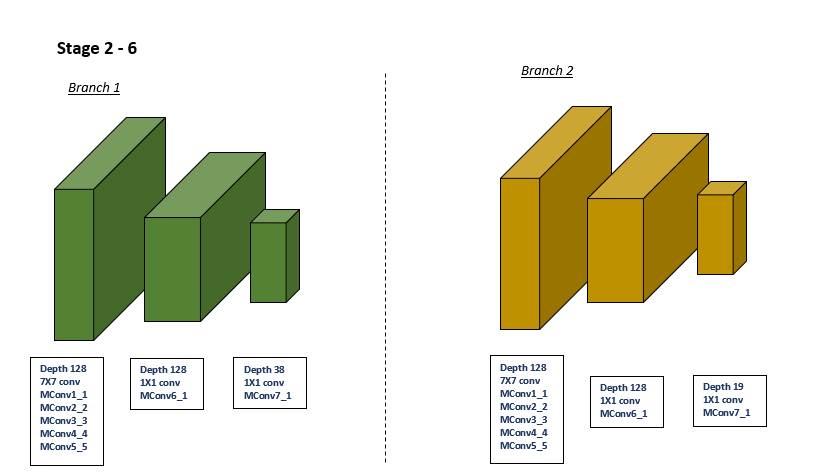

The refinement of the confidence maps and affinity fields is made across stages. To guide the network to iteratively predict confidence maps of body parts in the first branch and PAFs in the second branch, it is applied two loss
functions at the end of each stage, one at each branch respectively.

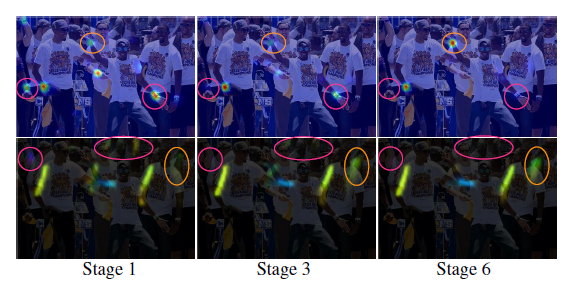

In the following code fragment you can see the detail of the network

In [16]:
model = get_model('vgg19')   
model.load_state_dict(torch.load(args.weight))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()

Bulding VGG19
Done !


DataParallel(
  (module): rtpose_model(
    (model0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

## ***Processing image***

Then we will proceed to test the performance of the network with a test image. In the following code the image to be tested is presented

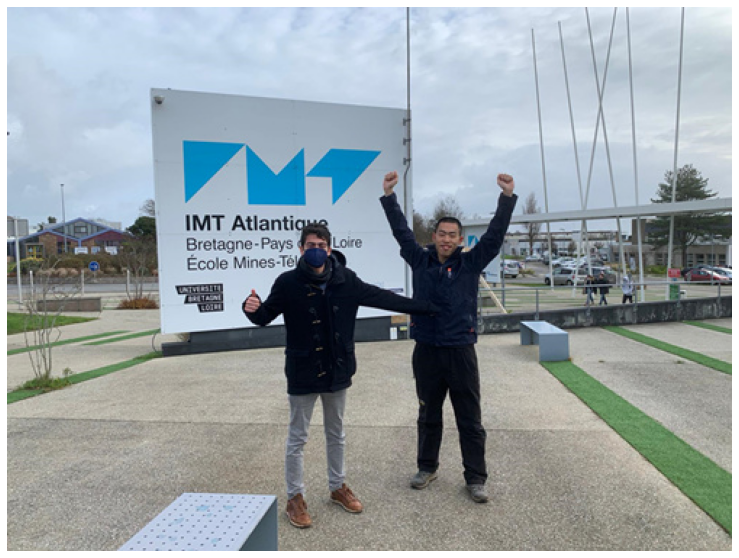

In [17]:
test_image = './readme/Authors.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
shape_dst = np.min(oriImg.shape[0:2])
destRGB = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20,10))
imgplot = plt.imshow(destRGB)
plt.axis('off')
plt.show()

You can also test on other images in the folder or upload your image

In [18]:
!pwd
!ls ./readme/

/content/gdrive/My Drive/Colab Notebooks/RT-multiperson-pose-pytorch
Authors.jpg	blank.jpg  curry.jpg   pose.png  training_structure.png
Authors_v2.mp4	cara.jpg   muchas.jpg  ski.jpg


### ***Confidence Maps for Part Detection and Part Affinity Fields for Part Association***

This section will show the different steps that the network runs in order to determine the position of people

***Maps for Part Detection***

Each confidence map is a 2D representation of the belief that a particular body part occurs at each pixel location. Ideally, if a single person occurs in the image, a single peak should exist in each confidence map if the corresponding part is visible; if multiple people occur, there should be a peak corresponding to each visible part j for each person k.

In [19]:
# Get results of original image

with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(oriImg, model,  'rtpose')
          
print('Mean Average Precision: {}'.format(im_scale))

Mean Average Precision: 0.9813333333333333


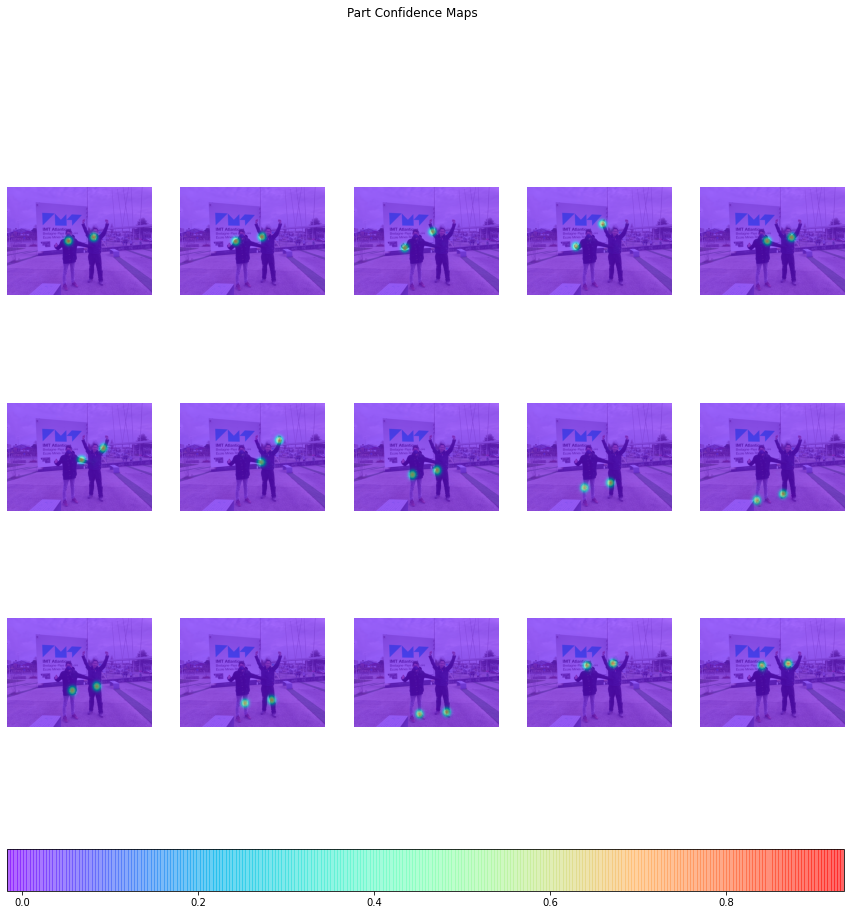

In [20]:
# There is a heat map by area of the body found as shown below
# Nose = 0, Neck = 1, RShoulder = 2, RElbow = 3, RWrist = 4, LShoulder = 5, LElbow = 6, LWrist = 7
# RHip = 8, RKnee = 9, RAnkle = 10, LHip = 11, LKnee = 12, LAnkle = 13, REye = 14, LEye = 15, REar = 16, 
# LEar = 17,Background = 18

from matplotlib import colors
Nr = 3
Nc = 5
Grahp=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
cmap='rainbow'
interpolation='bicubic'
alpha=.6


#img = plt.imread('./readme/Authors.jpg')
img = plt.imread(test_image)



fig, axs = plt.subplots(Nr, Nc,figsize=(15,15))
fig.suptitle('Part Confidence Maps')

images = []
aux =0

plt.imshow(img, alpha=1) # for image
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
for i in range(Nr):
    for j in range(Nc):
        # Generate data with a range that varies from one plot to the next.
        ImagMap=heatmap[:,:,Grahp[aux]]
        axs[i, j].imshow(img, alpha=1) 
        images.append(axs[i, j].imshow(ImagMap, cmap=cmap, interpolation=interpolation,alpha=alpha,extent=(xmin,xmax,ymin,ymax)))
        axs[i, j].label_outer()
        axs[i, j].grid(b=False)
        axs[i, j].axis('off')
        aux+=1

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

plt.grid(b=False)
plt.axis('off')
plt.show()


### Part Affinity Fields for Part Association
For each connection between the parts detected by the trusted potatoes, there are two layers that represent the affinity field of those connections. In other words, an affinity field shows the probable normalized direction of a pixel towards its corresponding connection pixel, and two coordinates ($x_{j_1,k}$ and $x_{j_2,k}$) for $k$-limb conection are needed to describe this direction. If we plot some part affinity fields in the original image, we can see the limb join field between two parts of the body, for each person. The following code show some part affinity fields in the original image:

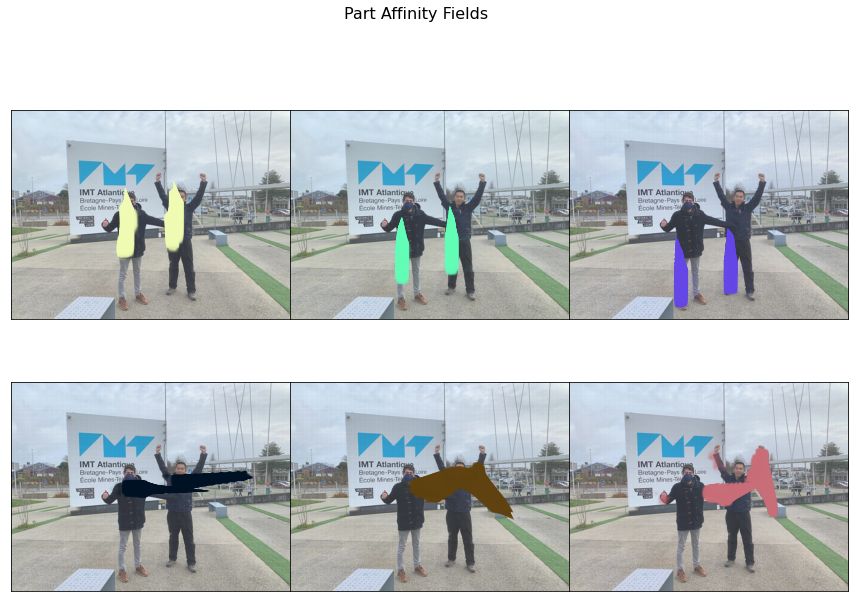

In [21]:
# The order to swap left and right of heatmap
    #swap_heat = np.array((0, 1, 5, 6, 7, 2, 3, 4, 11, 12,
                        #  13, 8, 9, 10, 15, 14, 17, 16, 18))

    # paf's order
    # 0,1 2,3 4,5
    # neck to right_hip, right_hip to right_knee, right_knee to right_ankle

    # 6,7 8,9, 10,11
    # neck to left_hip, left_hip to left_knee, left_knee to left_ankle

    # 12,13 14,15, 16,17, 18, 19
    # neck to right_shoulder, right_shoulder to right_elbow, right_elbow to
    # right_wrist, right_shoulder to right_ear

    # 20,21 22,23, 24,25 26,27
    # neck to left_shoulder, left_shoulder to left_elbow, left_elbow to
    # left_wrist, left_shoulder to left_ear

    # 28,29, 30,31, 32,33, 34,35 36,37
    # neck to nose, nose to right_eye, nose to left_eye, right_eye to
    # right_ear, left_eye to left_ear So the swap of paf should be:
    #swap_paf = np.array((6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 20, 21, 22, 23,
                       #  24, 25, 26, 27, 12, 13, 14, 15, 16, 17, 18, 19, 28,
                        # 29, 32, 33, 30, 31, 36, 37, 34, 35))

    #flipped_paf = flipped_paf[:, ::-1, :]

out_paf = np.zeros([paf.shape[2], img.shape[0], img.shape[1]])

for h in range(paf.shape[2]):
  out_paf[h] = cv2.resize(paf[:,:,h], (img.shape[1], img.shape[0]))
X, Y = np.meshgrid(np.arange(0, img.shape[1], 1) , np.arange(0, img.shape[0], 1))

fig, axs = plt.subplots(nrows= 2, ncols = 3, figsize = (15,10), sharex=True, sharey=True)
paf_view = [0,1,2,10,11,12]
colors = np.random.randint(0, 255, size = (2*3,3), dtype = "uint8") / 255.0
for i,ax in enumerate(axs.flatten()):
  ax.imshow(img, alpha = 0.8)
  ax.quiver(X, Y, out_paf[2*paf_view[i]], out_paf[2*paf_view[i] + 1], 
            minlength=0, alpha = 0.5, color = colors[i])
  ax.set_xticklabels([]); ax.set_yticklabels([])
  ax.set_xticks([]); ax.set_yticks([]); ax.axis("on")

fig.subplots_adjust(wspace=0.0,hspace=0.0)
fig.suptitle("Part Affinity Fields", fontsize=16)
fig.show()

mAP: 0.9813333333333333 


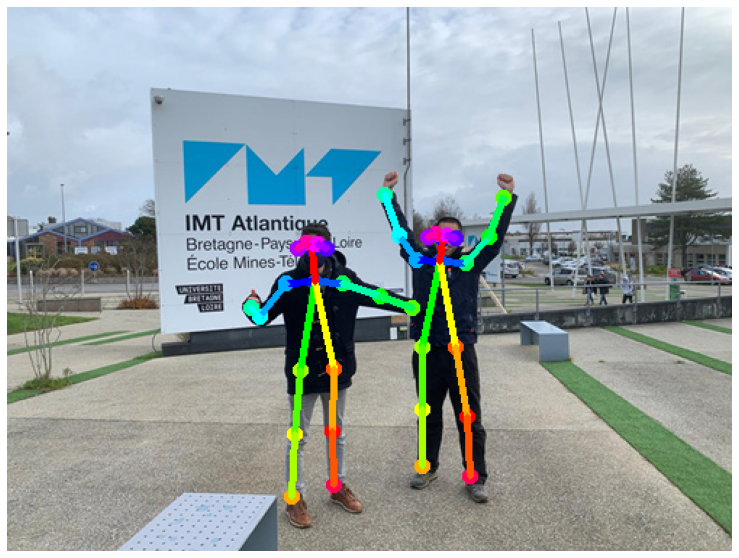

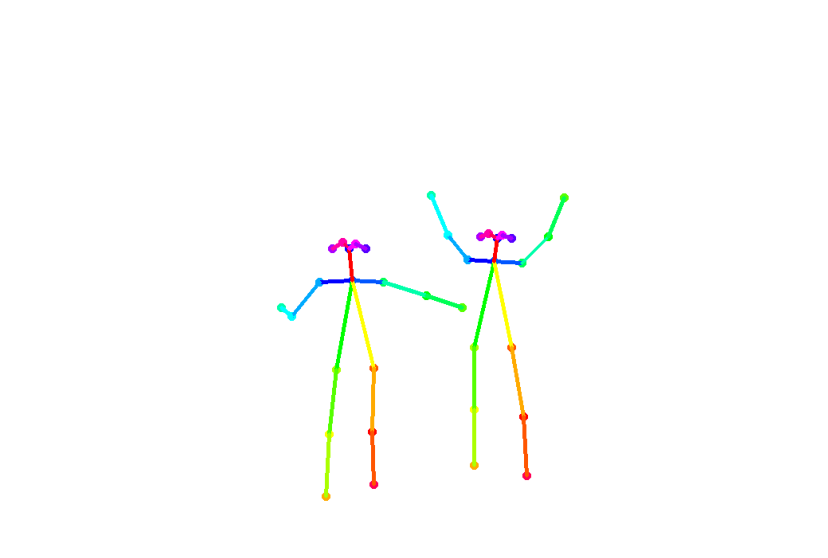

In [22]:
print("mAP: {} ".format(im_scale))

humans = paf_to_pose_cpp(heatmap, paf, cfg)
out = draw_humans(oriImg, humans)
destRGB_out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

white_image = './readme/blank.jpg'
background = cv2.imread(white_image) # B,G,R order
out_white = draw_humans(background, humans)
destRGB_white = cv2.cvtColor(out_white, cv2.COLOR_BGR2RGB)


plt.figure(figsize = (20,10))
imgplot = plt.imshow(destRGB_out)
plt.axis('off')
plt.show()

plt.figure(figsize = (20,10))
imgplot = plt.imshow(destRGB_white)
plt.axis('off')
plt.show()

# plt.figure(figsize = (20,10))
# fig, (ax1,ax2) = plt.subplots(1,2)
# fig.suptitle('Authors')

# imgplot = plt.imshow(destRGB_out)
# ax1.axis('off')
# imgplot = ax2.imshow(destRGB_white)
# ax2.axis('off')
# plt.show()

## Visualisation

torch.Size([1, 19, 62, 62])
torch.Size([1, 19, 62, 62])
torch.Size([1, 19, 62, 62])


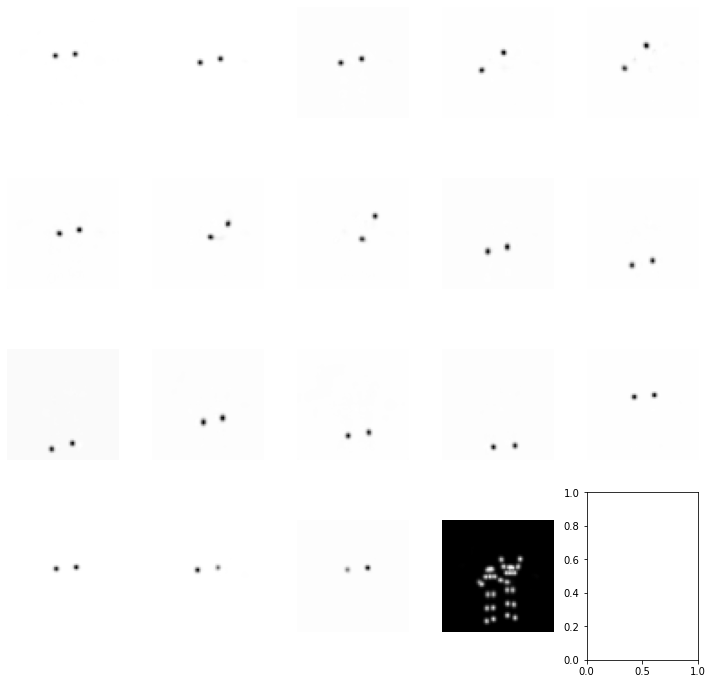

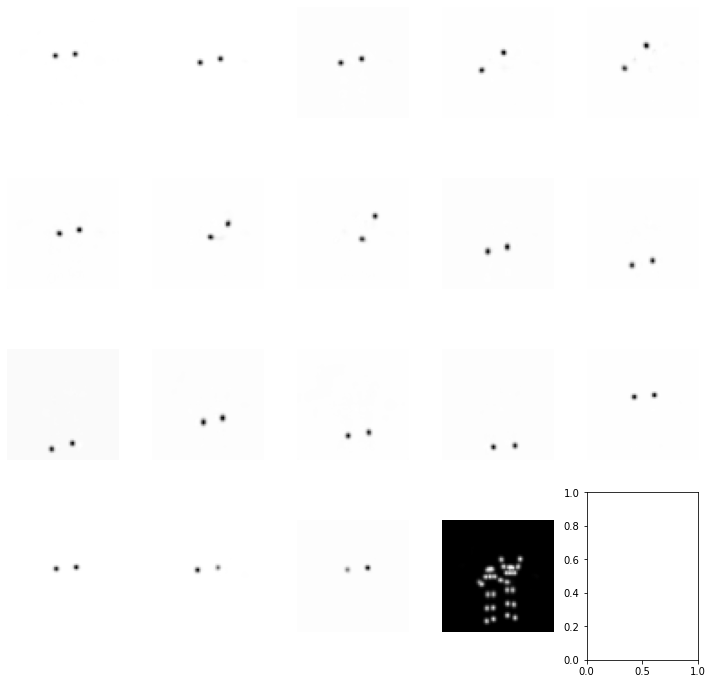

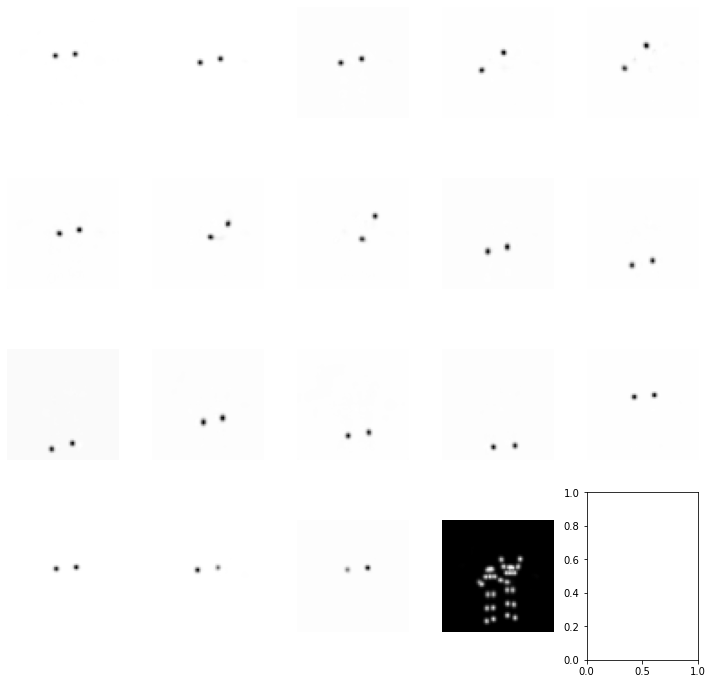

In [ ]:
from PIL import Image
import torch
from torchvision.models import resnet18
from torchvision import transforms as T

# input (single)
#image = './readme/ski.jpg'
image = Image.open('./readme/Authors.jpg')
transform = T.Compose([T.Resize((500, 500)), T.ToTensor()])
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
X = transform(image).unsqueeze(dim=0).to(device)

# original model
#model = resnet18(pretrained=True)
model = model.to(device)

# a dict to store the activations
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

# register forward hooks on the layers of choice
h1 = model.module.model6_2.register_forward_hook(getActivation('1'))
h2 = model.module.model6_2.register_forward_hook(getActivation('2'))
h3 = model.module.model6_2.register_forward_hook(getActivation('3'))

# forward pass -- getting the outputs
out = model(X)

#print(activation)
print(activation['1'].shape)
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for ax, fmap in zip(axes.flatten(), activation['1'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
    ax.axis('off')
plt.tight_layout()

print(activation['2'].shape)
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for ax, fmap in zip(axes.flatten(), activation['2'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
    ax.axis('off')
plt.tight_layout()

print(activation['3'].shape)
fig, axes = plt.subplots(4, 5, figsize=(10, 10))
for ax, fmap in zip(axes.flatten(), activation['3'].squeeze()):
    ax.imshow(fmap.detach().cpu().numpy(), cmap='binary')
    ax.set_xticks([])
    ax.axis('off')
plt.tight_layout()

plt.show()

# detach the hooks
h1.remove()
h2.remove()
h3.remove()

## Webcam images
Running code on images taken from webcam is fairly straight-forward. We will utilize code within Google Colab's **Code Snippets** that has a variety of useful code functions to perform various tasks.

We will be using the code snippet for **Camera Capture** to utilize your computer's webcam.

In [23]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [24]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  # faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  # for (x,y,w,h) in faces:
  #     img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  test_image = filename
  oriImg = cv2.imread(test_image) # B,G,R order
  shape_dst = np.min(oriImg.shape[0:2])
  destRGB = cv2.cvtColor(oriImg, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (20,10))
  imgplot = plt.imshow(destRGB)
  plt.axis('off')
  plt.show()

  with torch.no_grad():
    paf, heatmap, im_scale = get_outputs(oriImg, model,  'rtpose')
          
  #print('Mean Average Precision: {}'.format(im_scale))
  
  # There is a heat map by area of the body found as shown below
  # Nose = 0, Neck = 1, RShoulder = 2, RElbow = 3, RWrist = 4, LShoulder = 5, LElbow = 6, LWrist = 7
  # RHip = 8, RKnee = 9, RAnkle = 10, LHip = 11, LKnee = 12, LAnkle = 13, REye = 14, LEye = 15, REar = 16, 
  # LEar = 17,Background = 18

  from matplotlib import colors
  Nr = 3
  Nc = 5
  Grahp=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  cmap='rainbow'
  interpolation='bicubic'
  alpha=.6


  #img = plt.imread('./readme/ski.jpg')
  img = plt.imread(test_image)



  fig, axs = plt.subplots(Nr, Nc,figsize=(15,15))
  fig.suptitle('Part Confidence Maps')

  images = []
  aux =0

  plt.imshow(img, alpha=1) # for image
  xmin, xmax = plt.xlim()
  ymin, ymax = plt.ylim()
  for i in range(Nr):
      for j in range(Nc):
          # Generate data with a range that varies from one plot to the next.
          ImagMap=heatmap[:,:,Grahp[aux]]
          axs[i, j].imshow(img, alpha=1) 
          images.append(axs[i, j].imshow(ImagMap, cmap=cmap, interpolation=interpolation,alpha=alpha,extent=(xmin,xmax,ymin,ymax)))
          axs[i, j].label_outer()
          axs[i, j].grid(b=False)
          axs[i, j].axis('off')
          aux+=1

  # Find the min and max of all colors for use in setting the color scale.
  vmin = min(image.get_array().min() for image in images)
  vmax = max(image.get_array().max() for image in images)
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
      im.set_norm(norm)

  fig.colorbar(images[0], ax=axs, orientation='horizontal', fraction=.1)

  plt.grid(b=False)
  plt.axis('off')
  plt.show()
  
  # The order to swap left and right of heatmap
    #swap_heat = np.array((0, 1, 5, 6, 7, 2, 3, 4, 11, 12,
                        #  13, 8, 9, 10, 15, 14, 17, 16, 18))

    # paf's order
    # 0,1 2,3 4,5
    # neck to right_hip, right_hip to right_knee, right_knee to right_ankle

    # 6,7 8,9, 10,11
    # neck to left_hip, left_hip to left_knee, left_knee to left_ankle

    # 12,13 14,15, 16,17, 18, 19
    # neck to right_shoulder, right_shoulder to right_elbow, right_elbow to
    # right_wrist, right_shoulder to right_ear

    # 20,21 22,23, 24,25 26,27
    # neck to left_shoulder, left_shoulder to left_elbow, left_elbow to
    # left_wrist, left_shoulder to left_ear

    # 28,29, 30,31, 32,33, 34,35 36,37
    # neck to nose, nose to right_eye, nose to left_eye, right_eye to
    # right_ear, left_eye to left_ear So the swap of paf should be:
    #swap_paf = np.array((6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 20, 21, 22, 23,
                       #  24, 25, 26, 27, 12, 13, 14, 15, 16, 17, 18, 19, 28,
                        # 29, 32, 33, 30, 31, 36, 37, 34, 35))

    #flipped_paf = flipped_paf[:, ::-1, :]

  out_paf = np.zeros([paf.shape[2], img.shape[0], img.shape[1]])

  for h in range(paf.shape[2]):
    out_paf[h] = cv2.resize(paf[:,:,h], (img.shape[1], img.shape[0]))
  X, Y = np.meshgrid(np.arange(0, img.shape[1], 1) , np.arange(0, img.shape[0], 1))

  fig, axs = plt.subplots(nrows= 2, ncols = 3, figsize = (15,10), sharex=True, sharey=True)
  paf_view = [0,1,2,10,11,12]
  colors = np.random.randint(0, 255, size = (2*3,3), dtype = "uint8") / 255.0
  for i,ax in enumerate(axs.flatten()):
    ax.imshow(img, alpha = 0.8)
    ax.quiver(X, Y, out_paf[2*paf_view[i]], out_paf[2*paf_view[i] + 1], 
              minlength=0, alpha = 0.5, color = colors[i])
    ax.set_xticklabels([]); ax.set_yticklabels([])
    ax.set_xticks([]); ax.set_yticks([]); ax.axis("on")

  fig.subplots_adjust(wspace=0.0,hspace=0.0)
  fig.suptitle("Part Affinity Fields", fontsize=16)
  fig.show()

  #print("mAP: {} ".format(im_scale))
  humans = paf_to_pose_cpp(heatmap, paf, cfg)
          
  out = draw_humans(oriImg, humans)
  destRGB_2 = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (20,10))
  imgplot = plt.imshow(destRGB_2)
  plt.axis('off')
  plt.show()

  return filename

<IPython.core.display.Javascript object>

(480, 640)


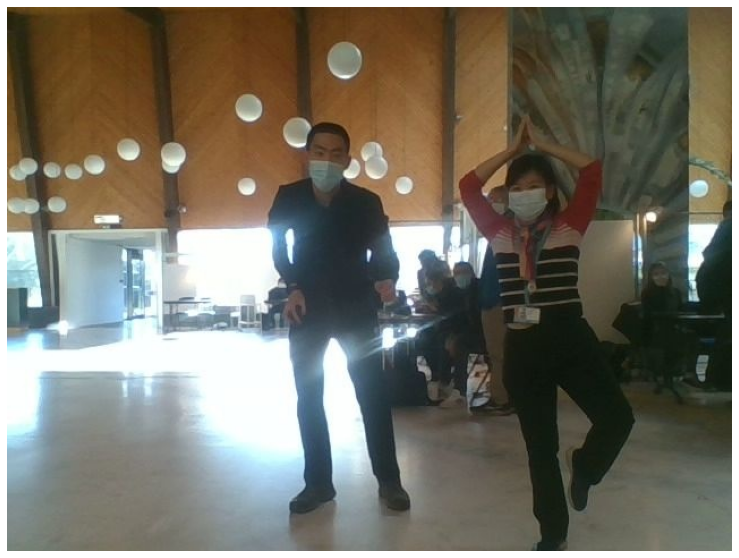

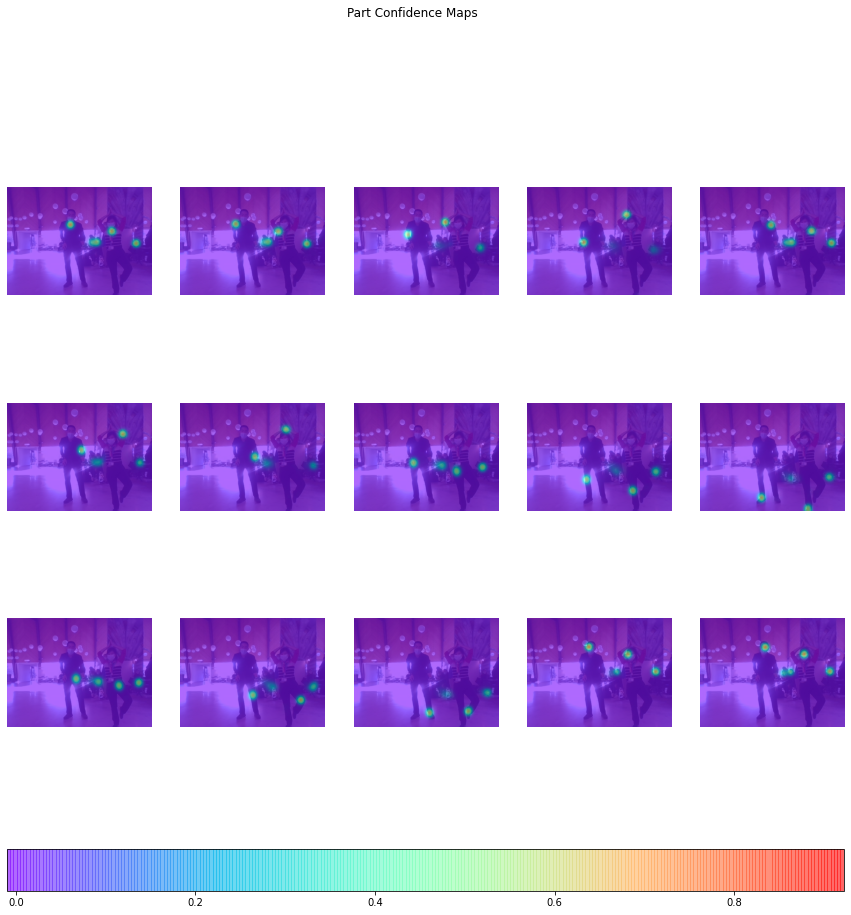

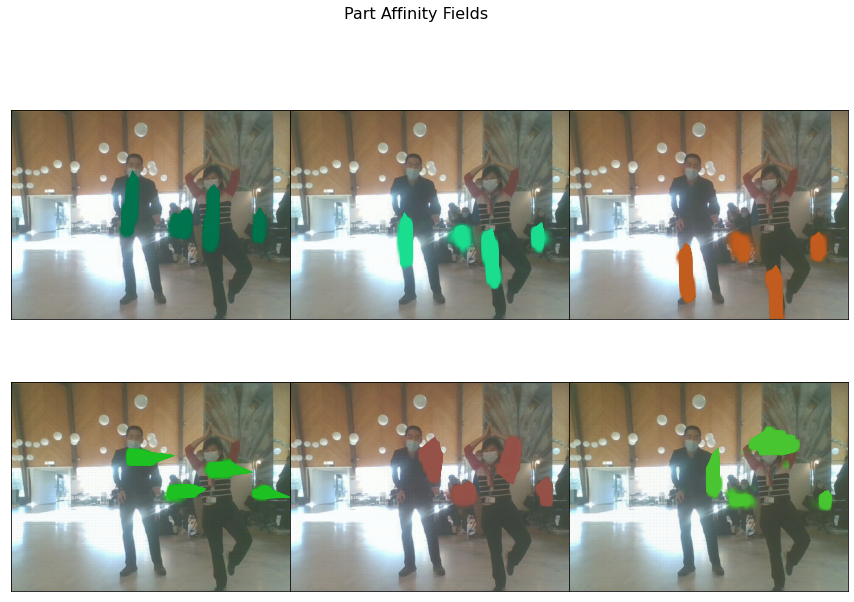

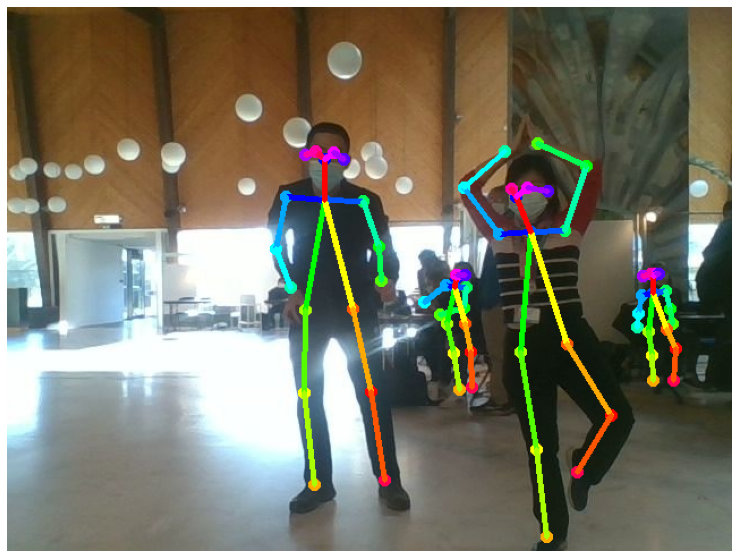

Saved to photo.jpg
photo.jpg


In [28]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  print(filename)  
  
  # Show the image which was just taken.
  # display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Webcam videos

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  img = js_to_image(js_reply["img"])
  print(img)
  ret, oriImg = img.read()
      
  shape_dst = np.min(oriImg.shape[0:2])

  with torch.no_grad():
      paf, heatmap, imscale = get_outputs(
          oriImg, model, 'rtpose')
            
  humans = paf_to_pose_cpp(heatmap, paf, cfg)
          
  out = draw_humans(oriImg, humans)

  # Display the resulting frame
  cv2.imshow('Video', out)

  if cv2.waitKey(1) & 0xFF == ord('q'):
      break



<IPython.core.display.Javascript object>

[[[102  99  78]
  [105 102  81]
  [109 105  86]
  ...
  [117 117 103]
  [117 116 102]
  [117 116 102]]

 [[102  99  78]
  [104 101  80]
  [108 104  85]
  ...
  [114 114 100]
  [115 114 100]
  [115 114 100]]

 [[105 100  79]
  [106 101  80]
  [109 103  84]
  ...
  [114 114 100]
  [114 114 100]
  [114 114 100]]

 ...

 [[104 126 114]
  [105 127 115]
  [105 127 115]
  ...
  [ 77  98  76]
  [ 77  96  75]
  [ 77  96  75]]

 [[105 127 115]
  [106 128 116]
  [106 128 116]
  ...
  [ 79  98  77]
  [ 80  97  76]
  [ 80  97  76]]

 [[112 134 122]
  [112 134 122]
  [112 134 122]
  ...
  [ 81  98  77]
  [ 81  96  75]
  [ 80  95  74]]]


AttributeError: ignored

In [ ]:
stream = navigator.mediaDevices.getUserMedia({video: true});
data = eval_js('takePhoto({})'.format(quality))

NameError: ignored

## Processing videos

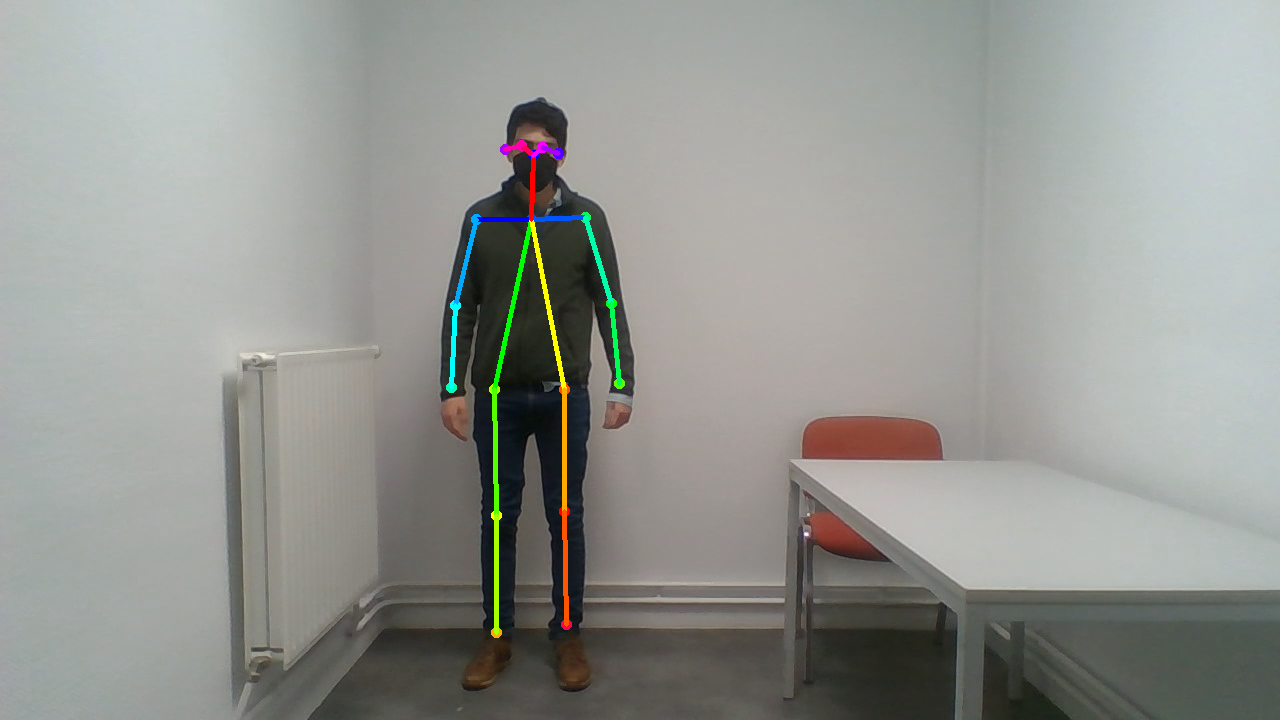

End of video


In [ ]:
#import cv2
from google.colab.patches import cv2_imshow

#filename = './group3/VideoColor_Correct0.avi'
#You should also do it with the other videos, for example 
filename = './readme/Authors_v2.mp4'

images =[]
video_capture = cv2.VideoCapture(filename)

#for the output file
# We need to set resolutions. 
# so, convert them from float to integer. 
frame_width = int(video_capture.get(3)) 
frame_height = int(video_capture.get(4)) 
   
size = (frame_width, frame_height) 
   
# Below VideoWriter object will create 
# a frame of above defined The output  
# is stored in 'filename.avi' file. 
result = cv2.VideoWriter('./output_v2.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, size) 

for i in range(10): #only for 10 frames COMMENT OUT FOR THE WHOLE VIDEO TODO
#while video_capture.isOpened(): #for the whole video
        # Capture frame-by-frame
        is_success, oriImg = video_capture.read()
        if not is_success:
            break
        
        shape_dst = np.min(oriImg.shape[0:2])

        with torch.no_grad():
            paf, heatmap, imscale = get_outputs(
                oriImg, model, 'rtpose')
                  
        humans = paf_to_pose_cpp(heatmap, paf, cfg)
                
        out = draw_humans(oriImg, humans)

        # Display the resulting frame
        output.clear()
        images.append(out)
        cv2_imshow(out)
        # Write the frame into the 
        # output file 
        result.write(out) 

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the capture
video_capture.release()
#cv2.destroyAllWindows()
print("End of video")

In [ ]:
from IPython.display import Image
from numpngw import write_apng

imageio.mimsave('a2c.gif', [np.array(img) for i, img in enumerate(images) if i%2 == 0], fps=29)
write_apng('outvideo.png', images, delay=20)
Image(filename='outvideo.png')

NameError: ignored

You can read the details of the COCO model skeleton in https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/02_output.md
The list of joints is:
0. Head
1. mShoulder
2. rShoulder
3. rElbow
4. rWrist
5. lShoulder
6. lElbow
7. lWrist
8. rHip
9. rKnee
10. rAnkle
11. lHip
12. lKnee
13. lAnkle

In [ ]:
# Body Model given as a dictionary of the body parts
body_parts={0:"Head",1:"mShoulder",2:"rShoulder",3:"rElbow",4:"rWrist",5:"lShoulder",6:"lElbow",7:"lWrist",8:"rHip",9:"rKnee",10:"rAnkle",11:"lHip",12:"lKnee",13:"lAnkle"}


##Control a robot
**Program the robot to perform the same exercises**. 



You can use a robot using pybullet physical simulator. Documentation about pybullet can be read on https://pybullet.org/wordpress/index.php/forum-2/.
Below is an example of code to use a robot arm or a humanoid agent.

In [ ]:
#INSTALL THE PACKAGES
!pip3 install pybullet --upgrade
!pip3 install stable_baselines --upgrade
!pip3 install tensorflow==1.14.0 #tensorflow deprecates and breaks their API
#see PyBullet Quickstart Guide at
#https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit
!pip install pyvirtualdisplay > /dev/null 2>&1

     |████████████████████████████████| 90.8 MB 280 bytes/s 
     |████████████████████████████████| 240 kB 2.7 MB/s 
     |████████████████████████████████| 109.3 MB 67 kB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 3.1 MB 41.4 MB/s 
     |████████████████████████████████| 488 kB 40.4 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.7.0
    Uninstalling tensorflow-2.7.0:
      Successfully uninstalled tensorflow-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [ ]:
#connect to the physical simulator
import pybullet
import pybullet_data
datapath = pybullet_data.getDataPath()
pybullet.connect(pybullet.DIRECT)

ModuleNotFoundError: ignored

The implementation of the Kuka robot arm can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/bullet/kukaGymEnv.py.

The implementation of the humanoid, ant ... can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_locomotion_envs.py. 

The implementation fo the reacher can be found in https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/gym_manipulator_envs.py